# Delay Coordinates & Neighborhoods


Topics:
* Delay coordinates & why they ROCK!
* A `Reconstruction` is a subtype of `AbstractDataset`
* Estimating Parameters for `Reconstruction`s
* Multiple-time, multiple timeseries `Reconstruction`s
* Finding neighborhoods of points in a `Dataset`
* Excluding temporal neighbors

---

# Delay Coordinates Reconstruction
Let's say you have a "real-world system" which you measure in an experimental set-up. You are assuming that the system is composed of several dynamic variables, but you can only measure one of them (or some function of the variable).

You have a severe lack of recorded information for the system. What do you do?
1. Give up on science, it is a complete waste of time.
2. Use [Taken's theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem), which is indistinguishable from magic.

**DynamicalSystems.jl** suggests the third approach.

From a timeseries $s$ one can *reconstruct* a state-space $\mathbf{z}$ simply by shifting $s$ in time, like
  
  $$\mathbf{z}(n) = (s(n), s(n+\tau), s(n+2\tau), \dots, s(n+D\tau))$$
  
This is done with the `reconstruct(s, D, τ)` function

In [1]:
using DynamicalSystems

In [2]:
s = rand(100000)
D = 3 # how many temporal neighbors?
τ = 4 # reconstruction delay
R = reconstruct(s, D, τ)

4-dimensional Dataset{Float64} with 99988 points
 0.495324   0.354389   0.761251   0.196267 
 0.174015   0.573645   0.453957   0.682715 
 0.758903   0.0108251  0.45025    0.206483 
 0.831319   0.215676   0.477462   0.470187 
 0.354389   0.761251   0.196267   0.650776 
 0.573645   0.453957   0.682715   0.172776 
 0.0108251  0.45025    0.206483   0.531138 
 0.215676   0.477462   0.470187   0.318724 
 0.761251   0.196267   0.650776   0.715732 
 0.453957   0.682715   0.172776   0.946724 
 0.45025    0.206483   0.531138   0.723807 
 0.477462   0.470187   0.318724   0.158102 
 0.196267   0.650776   0.715732   0.181423 
 ⋮                                         
 0.436754   0.0750185  0.526258   0.509834 
 0.946428   0.203842   0.608407   0.632979 
 0.173277   0.0570724  0.19319    0.904505 
 0.0311462  0.0179074  0.242885   0.472028 
 0.0750185  0.526258   0.509834   0.0480799
 0.203842   0.608407   0.632979   0.316015 
 0.0570724  0.19319    0.904505   0.900934 
 0.0179074  0.242885   0.47

---

Here are some nice examples of `Reconstruction`s of a 3D continuous chaotic system, using each of the variables of the system, different delay times and dimension of `2`:

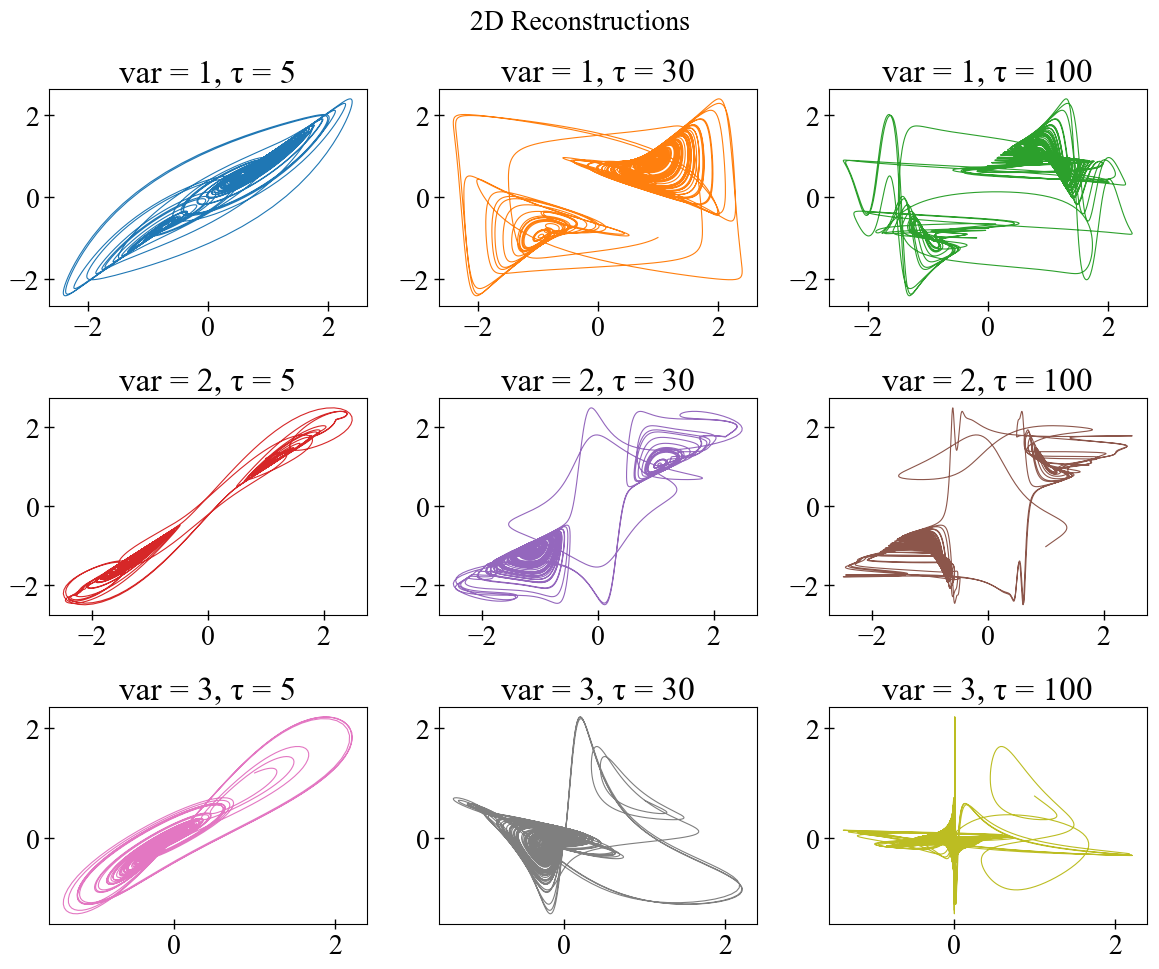

In [3]:
using DynamicalSystems, PyPlot

ds = Systems.gissinger(ones(3)) # 3D continuous chaotic system, also shown in orbit diagrams tutorial
dt = 0.05
data = trajectory(ds, 1000.0, dt = dt)

xyz = columns(data)

figure(figsize = (12,10))
k = 1
for i in 1:3
    for τ in [5, 30, 100]
        R = reconstruct(xyz[i], 1, τ)
        ax = subplot(3,3,k)
        plot(R[:, 1], R[:, 2], color = "C$(k-1)", lw = 0.8)
        title("var = $i, τ = $τ")
        k+=1
    end
end

tight_layout()
suptitle("2D Reconstructions")
subplots_adjust(top=0.9);

How does this compare to the "real" two-dimensional representation of the system?

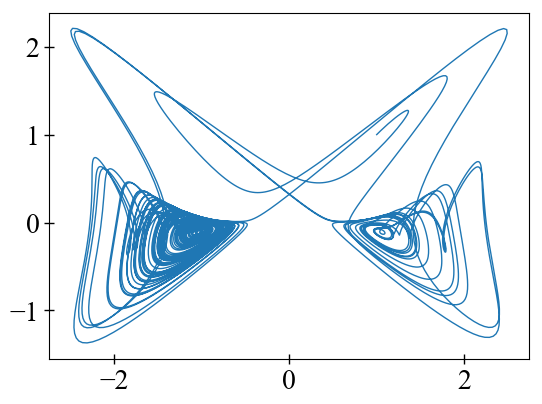

In [4]:
figure(figsize=(6,4))
plot(data[:, 2], data[:, 3], lw=1.0);

---

## `reconstruct` returns `Dataset`
Which means that any manipulation shown in tutorial n. 1, can be applied immediatelly to the result of a reconstruction.

* This *includes* dimension estimation!

**Taken's theorem says that some quantities remain invariant under a reconstruction**

We'll show this by doing `reconstruct` with 1 and 2 temporal neighbors.
(D = 2 is best for this system)

In [5]:
R = reconstruct(data[:, 1], 2, 30)

3-dimensional Dataset{Float64} with 19941 points
 1.0       -0.984837  -1.48932 
 0.953553  -1.01922   -1.49026 
 0.90227   -1.05132   -1.48912 
 0.846142  -1.08134   -1.48561 
 0.785246  -1.10948   -1.47943 
 0.719745  -1.1359    -1.47025 
 0.649903  -1.16077   -1.4577  
 0.576079  -1.18424   -1.44137 
 0.498731  -1.20646   -1.42086 
 0.418402  -1.22754   -1.39571 
 0.335711  -1.24759   -1.36549 
 0.251332  -1.26671   -1.32974 
 0.165978  -1.28499   -1.28802 
 ⋮                             
 0.742844   0.462079   0.775475
 0.7184     0.469155   0.785355
 0.694487   0.476871   0.795083
 0.671207   0.485171   0.804661
 0.648658   0.493998   0.814089
 0.626932   0.503298   0.823371
 0.606116   0.513016   0.83251 
 0.586288   0.523102   0.841508
 0.56752    0.533507   0.850371
 0.549875   0.544184   0.859101
 0.533408   0.555088   0.867704
 0.518163   0.566178   0.876183


Let's compare the information dimension of the `Reconstruction`

In [6]:
I1 = information_dim(R)

1.7802595497812008

and the information dimension of the attractor directly

In [7]:
I2 = information_dim(data)

1.7098106326429445

In [8]:
println("|Reconstructed - original| dimension: $(abs(I1 - I2))")

|Reconstructed - original| dimension: 0.0704489171382563


# Estimating Reconstruction Parameters

It is important to understand that even though Taken's theorem is 99% magic, it is **not** 100%. One still has to choose "appropriately good" values for both the delay time as well as the reconstruction dimension! Thankfully, **DynamicalSystems.jl** has some support for that as well!

* `estimate_delay` estimates delay time `τ` using the autocorrelation of the signal
* `estimate_dimension` returns an estimator for the amount of temporal neighbors `D` using Cao's method

# Multiple-time, multiple-timeseries Reconstructions

The `reconstruct` we have seen so far is just a "Vanilla version"...

One can also perform:

1. Reconstructions with multiple delay times, which tries to capture the effect of multiple timescales existing in a system.
2. Reconstructions with multiple timeseries.
3. Reconstructions with multiple timeseries *and* multiple delay times!

See the documentation string of `reconstruct` for more!

# Neighborhoods 

A "neighborhood" is a collection of points that is near a given point. `Dataset`s interface the module [`NearestNeighbors`](https://github.com/KristofferC/NearestNeighbors.jl) in order to find this neighborhood.

We use the function `neighborhood`. The call signature is:
```julia
neighborhood(point, tree, ntype)
```


`point` is simply the query point. `tree` is the structure required by [`NearestNeighbors`](https://github.com/KristofferC/NearestNeighbors.jl), and is obtained simply by:

In [9]:
dataset = Dataset(rand(1000,3))
tree = KDTree(dataset)

KDTree{StaticArrays.SArray{Tuple{3},Float64,1,3},Euclidean,Float64}
  Number of points: 1000
  Dimensions: 3
  Metric: Euclidean(0.0)
  Reordered: true

The third argument to `neighborhood` is the *type* of the neighborhood. 

* There are two types of neighborhoods!

The first one is defined as the `k` nearest points to a given point. It is represented in code by:

In [10]:
mybuddies = FixedMassNeighborhood(3)

FixedMassNeighborhood(3)

*For experts: for a `FixedMassNeighborhood` a KNN search is done*

In [11]:
point = ones(3)
n = neighborhood(point, tree, mybuddies)

3-element Array{Int64,1}:
 719
 175
 843

Notice that the `neighborhood` function does not return the points themselves, but rather the indices of the points in the original data:

In [12]:
println("Fixed mass neighborhood of $(point) is:")

for i in n
    println(dataset[i])
end

Fixed mass neighborhood of [1.0, 1.0, 1.0] is:
[0.94428, 0.909157, 0.81873]
[0.920896, 0.840456, 0.888393]
[0.811471, 0.94311, 0.950079]


---

The second type of neighborhood contains all the points that are within some given distance `ε` from the query.

In code, we represent this as:

In [13]:
where_u_at = FixedSizeNeighborhood(0.001)

FixedSizeNeighborhood(0.001)

 *For experts: for `FixedSizeNeighborhood` an inrange search is done*

In [14]:
n2 = neighborhood(point, tree, where_u_at)

0-element Array{Int64,1}

In [15]:
plz_come_closer = FixedSizeNeighborhood(0.2)
n2 = neighborhood(point, tree, plz_come_closer)

0-element Array{Int64,1}

In [16]:
println("Fixed size neighborhood of $(point) is:")

for i in n2
    println(dataset[i])
end

Fixed size neighborhood of [1.0, 1.0, 1.0] is:


Okay, so points that have distance < ε are accepted as a neighborhood.

How do we define the "distance" though? When defining a `tree`, you can optionally give a distance function. By default Euclidean distance is used, but others also work. For example, we can use the `Distances` package to get distance functions,

In [17]:
using Distances

and define the distance as the `Distances`'s `Chebyshev` distance:

In [18]:
funky_tree = KDTree(dataset, Chebyshev())

KDTree{StaticArrays.SArray{Tuple{3},Float64,1,3},Chebyshev,Float64}
  Number of points: 1000
  Dimensions: 3
  Metric: Chebyshev()
  Reordered: true

In [19]:
n3 = neighborhood(point, funky_tree, plz_come_closer)

5-element Array{Int64,1}:
 175
 171
 719
 483
 843

# Excluding temporal neighbors

Before moving on, let's see one last thing.

In this example, the point I want the neighborhood of is now part of my dataset:

In [20]:
point = dataset[end]

3-element StaticArrays.SArray{Tuple{3},Float64,1,3}:
 0.5375403563043124 
 0.10557324660546286
 0.5789517543089768 

Let's calculate again the two neighborhoods

In [21]:
tree = KDTree(dataset)

KDTree{StaticArrays.SArray{Tuple{3},Float64,1,3},Euclidean,Float64}
  Number of points: 1000
  Dimensions: 3
  Metric: Euclidean(0.0)
  Reordered: true

We'll find suuuuuuuper close neighbors with a **very** small $\epsilon$:

In [22]:
ε = 0.000001
where_u_at = FixedSizeNeighborhood(ε)
n2 = neighborhood(point, tree, where_u_at)

1-element Array{Int64,1}:
 1000

and now we can find the nearest neighbor:

In [23]:
my_best_friend = FixedMassNeighborhood(1)
n3 = neighborhood(point, tree, my_best_friend)

println(n2)
println(n3)

[1000]
[1000]


In [24]:
length(dataset) == n2[1] == n3[1]

true

**What is happening here is that the `neighborhood` also counted the `point` itself, since it is also part of the dataset.**

* Almost always this behavior needs to be avoided. For this reason, there is a second method for `neighborhood`:

```julia
neighborhood(point, tree, ntype, idx::Int, w::Int = 1)
```

In this case, `idx` is the index of the point in the original data. `w` stands for the Theiler window (positive integer).

Only points that have index
`abs(i - idx) ≥ w` are returned as a neighborhood, to exclude close temporal neighbors.

* The default `w=1` is the case of excluding the `point` itself.

---

Let's revisit the last example (using the default value of `w = 1`):

In [25]:
point = dataset[end]
idx = length(dataset)

n2 = neighborhood(point, tree, where_u_at, idx)
n3 = neighborhood(point, tree, my_best_friend, idx)

println(n2)
println(n3)

Int64[]
[806]


As you can see, there isn't *any* neighbor of `point` with distance `< 0.000001` in this dataset, but there is always a nearest neighbor:

In [26]:
println(dataset[n3[1]], " is the nearest neighbor of ", point)

[0.518726, 0.124829, 0.603393] is the nearest neighbor of [0.53754, 0.105573, 0.578952]


# Docstrings

In [27]:
?Reconstruction

search: Reconstruct reconstruct

Couldn't find Reconstruction
Perhaps you meant Reconstruct or reconstruct


No documentation found.

Binding `Reconstruction` does not exist.


In [28]:
?neighborhood

search: neighborhood AbstractNeighborhood FixedSizeNeighborhood



```
neighborhood(point, tree, ntype)
neighborhood(point, tree, ntype, n::Int, w::Int = 1)
```

Return a vector of indices which are the neighborhood of `point` in some `data`, where the `tree` was created using `tree = KDTree(data [, metric])`. The `ntype` is the type of neighborhood and can be any subtype of [`AbstractNeighborhood`](@ref).

Use the second method when the `point` belongs in the data, i.e. `point = data[n]`. Then `w` stands for the Theiler window (positive integer). Only points that have index `abs(i - n) ≥ w` are returned as a neighborhood, to exclude close temporal neighbors. The default `w=1` is the case of excluding the `point` itself.

## References

`neighborhood` simply interfaces the functions `knn` and `inrange` from [NearestNeighbors.jl](https://github.com/KristofferC/NearestNeighbors.jl) by using the argument `ntype`.


In [29]:
?AbstractNeighborhood

search: AbstractNeighborhood



```
AbstractNeighborhood
```

Supertype of methods for deciding the neighborhood of points for a given point.

Concrete subtypes:

  * `FixedMassNeighborhood(K::Int)` : The neighborhood of a point consists of the `K` nearest neighbors of the point.
  * `FixedSizeNeighborhood(ε::Real)` : The neighborhood of a point consists of all neighbors that have distance < `ε` from the point.

See [`neighborhood`](@ref) for more.
